#### free test

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from scipy import optimize
import glob
from pprint import pprint
import matplotlib.cm as cm

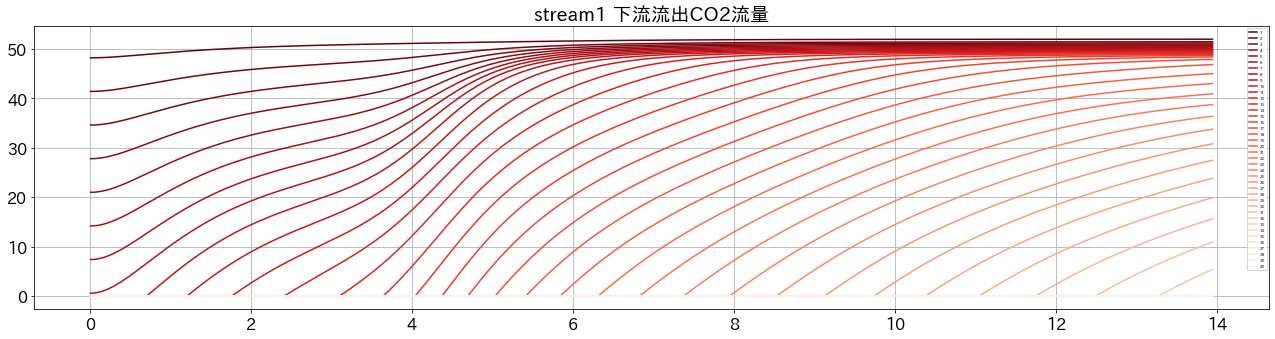

In [19]:
tgt = "下流流出CO2流量"
df = pd.read_csv(f"../output/2_21_num_section_40/simulation/csv/{tgt}.csv",
                 index_col="timestamp")

tgt_cols_1 = [col for col in df.columns if col.split("_")[-2][-1] == "1"]
tgt_cols_2 = [col for col in df.columns if col.split("_")[-2][-1] == "2"]
tgt_cols_3 = [col for col in df.columns if col.split("_")[-2][-1] == "3"]
fig = plt.figure(figsize=(18, 5), tight_layout=True)
fig.patch.set_facecolor('white')
plt.rcParams["font.size"] = 16
for i in range(len(tgt_cols_1)):
    plt.plot(df[tgt_cols_1[i]], label=i+1, color=cm.Reds_r(i/len(tgt_cols_1)))
    # plt.plot(df[tgt_cols_2[i]], label=i+1, color=cm.Blues_r(i/len(tgt_cols_2)))
    # plt.plot(df[tgt_cols_3[i]], label=i+1, color=cm.Greens_r(i/len(tgt_cols_3)))
plt.legend(fontsize=4)
plt.grid()
# plt.xlim([-0.5, 2])
# plt.ylim([17.9, 18.3])
plt.title(f"stream1 {tgt}")
plt.show()

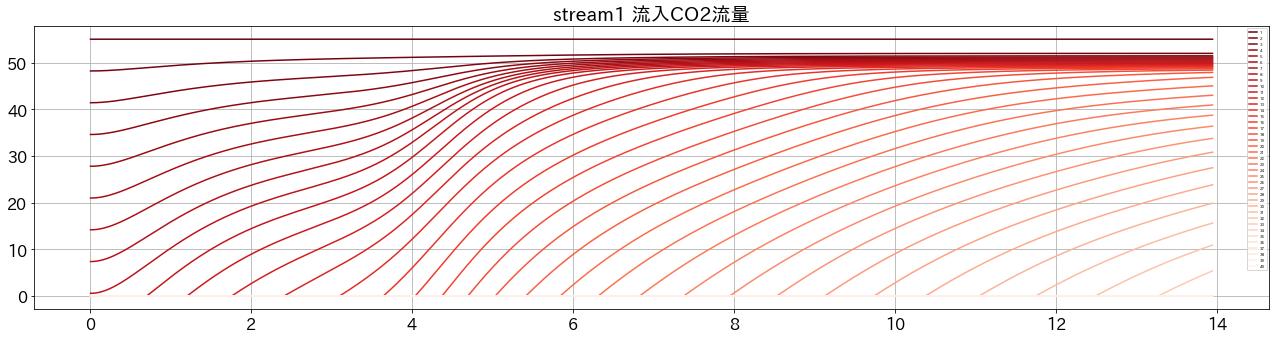

In [18]:
tgt = "流入CO2流量"
df = pd.read_csv(f"../output/2_21_num_section_40/simulation/csv/{tgt}.csv",
                 index_col="timestamp")

tgt_cols_1 = [col for col in df.columns if col.split("_")[-2][-1] == "1"]
tgt_cols_2 = [col for col in df.columns if col.split("_")[-2][-1] == "2"]
tgt_cols_3 = [col for col in df.columns if col.split("_")[-2][-1] == "3"]
fig = plt.figure(figsize=(18, 5), tight_layout=True)
fig.patch.set_facecolor('white')
plt.rcParams["font.size"] = 16
for i in range(len(tgt_cols_1)):
    plt.plot(df[tgt_cols_1[i]], label=i+1, color=cm.Reds_r(i/len(tgt_cols_1)))
    # plt.plot(df[tgt_cols_2[i]], label=i+1, color=cm.Blues_r(i/len(tgt_cols_2)))
    # plt.plot(df[tgt_cols_3[i]], label=i+1, color=cm.Greens_r(i/len(tgt_cols_3)))
plt.legend(fontsize=4)
plt.grid()
# plt.xlim([-0.5, 2])
# plt.ylim([17.9, 18.3])
plt.title(f"stream1 {tgt}")
plt.show()

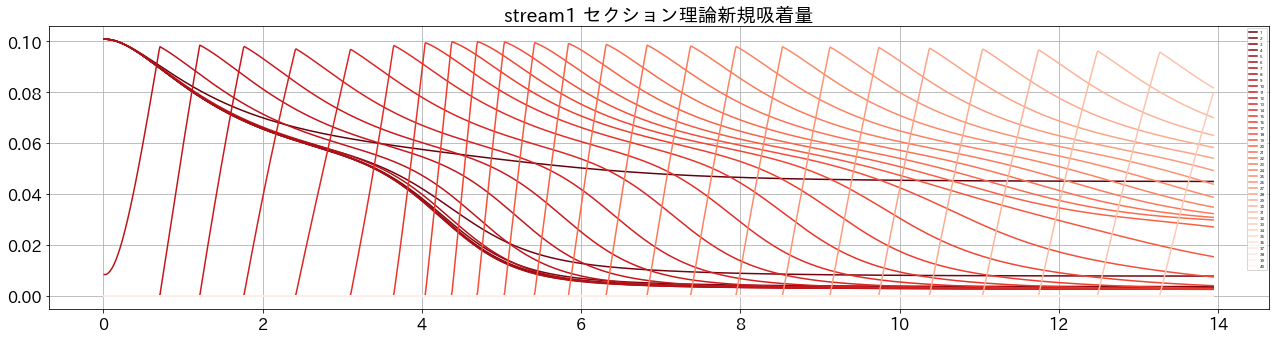

In [21]:
tgt = "セクション理論新規吸着量"
df = pd.read_csv(f"../output/2_21_num_section_40/simulation/csv/{tgt}.csv",
                 index_col="timestamp")

tgt_cols_1 = [col for col in df.columns if col.split("_")[-2][-1] == "1"]
tgt_cols_2 = [col for col in df.columns if col.split("_")[-2][-1] == "2"]
tgt_cols_3 = [col for col in df.columns if col.split("_")[-2][-1] == "3"]
fig = plt.figure(figsize=(18, 5), tight_layout=True)
fig.patch.set_facecolor('white')
plt.rcParams["font.size"] = 16
for i in range(len(tgt_cols_1)):
    plt.plot(df[tgt_cols_1[i]], label=i+1, color=cm.Reds_r(i/len(tgt_cols_1)))
    # plt.plot(df[tgt_cols_2[i]], label=i+1, color=cm.Blues_r(i/len(tgt_cols_2)))
    # plt.plot(df[tgt_cols_3[i]], label=i+1, color=cm.Greens_r(i/len(tgt_cols_3)))
plt.legend(fontsize=4)
plt.grid()
# plt.xlim([-0.5, 2])
# plt.ylim([17.9, 18.3])
plt.title(f"stream1 {tgt}")
plt.show()

---

In [18]:
df = pd.read_csv("../output/2_21_num_section_40/simulation/csv/セクション到達温度.csv",
                 index_col="timestamp")

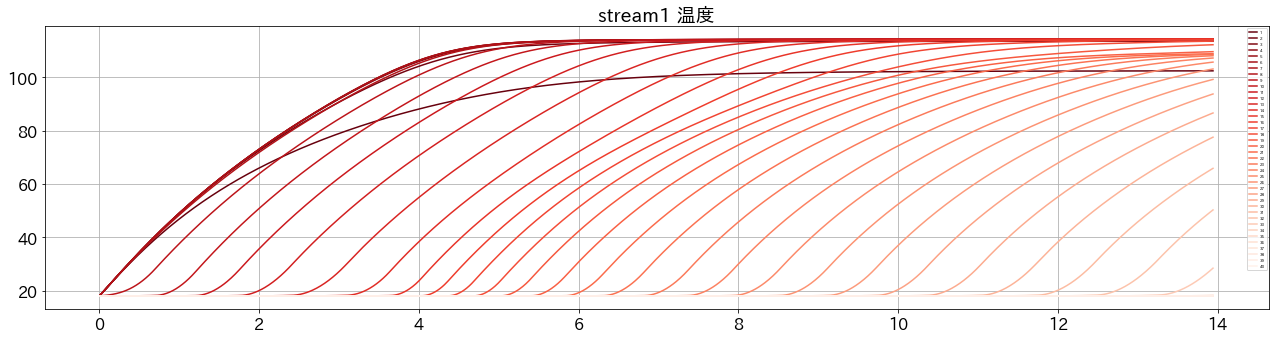

In [21]:
tgt_cols_1 = [col for col in df.columns if col.split("_")[-2][-1] == "1"]
tgt_cols_2 = [col for col in df.columns if col.split("_")[-2][-1] == "2"]
tgt_cols_3 = [col for col in df.columns if col.split("_")[-2][-1] == "3"]
fig = plt.figure(figsize=(18, 5), tight_layout=True)
fig.patch.set_facecolor('white')
plt.rcParams["font.size"] = 16
for i in range(len(tgt_cols_1)):
    plt.plot(df[tgt_cols_1[i]], label=i+1, color=cm.Reds_r(i/len(tgt_cols_1)))
    # plt.plot(df[tgt_cols_2[i]], label=i+1, color=cm.Blues_r(i/len(tgt_cols_2)))
    # plt.plot(df[tgt_cols_3[i]], label=i+1, color=cm.Greens_r(i/len(tgt_cols_3)))
plt.legend(fontsize=4)
plt.grid()
# plt.xlim([-0.5, 2])
# plt.ylim([17.9, 18.3])
plt.title("stream1 温度")
plt.show()

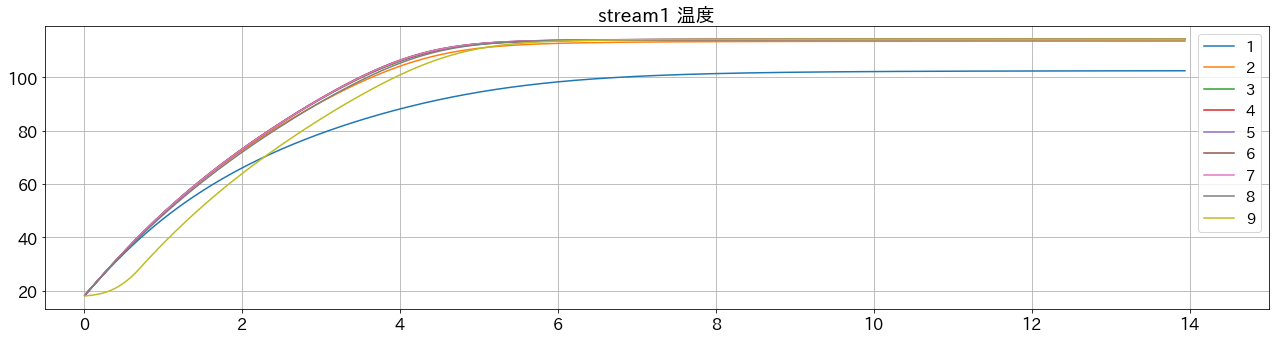

In [26]:
tgt_cols_1 = [col for col in df.columns if col.split("_")[-2][-1] == "1"]
fig = plt.figure(figsize=(18, 5), tight_layout=True)
fig.patch.set_facecolor('white')
plt.rcParams["font.size"] = 16
plt.plot(df[tgt_cols_1[0]], label=1)#, color=cm.Reds_r(0/len(tgt_cols_1)))
plt.plot(df[tgt_cols_1[1]], label=2)#, color=cm.Reds_r(1/len(tgt_cols_1)))
plt.plot(df[tgt_cols_1[2]], label=3)#, color=cm.Reds_r(1/len(tgt_cols_1)))
plt.plot(df[tgt_cols_1[3]], label=4)#, color=cm.Reds_r(1/len(tgt_cols_1)))
plt.plot(df[tgt_cols_1[4]], label=5)#, color=cm.Reds_r(1/len(tgt_cols_1)))
plt.plot(df[tgt_cols_1[5]], label=6)#, color=cm.Reds_r(1/len(tgt_cols_1)))
plt.plot(df[tgt_cols_1[6]], label=7)#, color=cm.Reds_r(1/len(tgt_cols_1)))
plt.plot(df[tgt_cols_1[7]], label=8)#, color=cm.Reds_r(1/len(tgt_cols_1)))
plt.plot(df[tgt_cols_1[8]], label=9)#, color=cm.Reds_r(1/len(tgt_cols_1)))
# plt.plot(df[tgt_cols_1[5]], label=5)#, color=cm.Reds_r(1/len(tgt_cols_1)))
# plt.plot(df[tgt_cols_1[6]], label=6)#, color=cm.Reds_r(1/len(tgt_cols_1)))
# plt.plot(df[tgt_cols_1[19]], label=19)#, color=cm.Reds_r(1/len(tgt_cols_1)))
plt.legend(fontsize=15)
plt.grid()
plt.xlim([-0.5, 15])
plt.title("stream1 温度")
plt.show()

---

In [3]:
df = pd.read_csv("../output/2_20_mod_num_section/simulation/csv/セクション到達温度.csv",
                 index_col="timestamp")

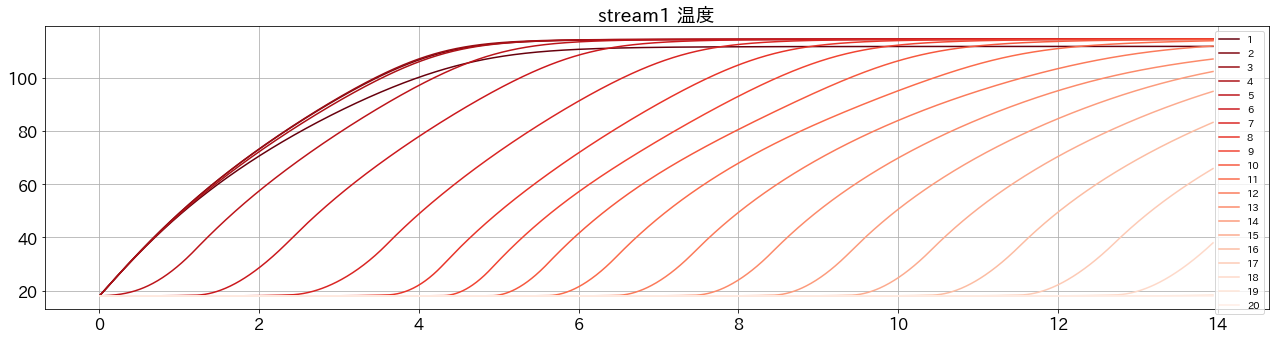

In [17]:
tgt_cols_1 = [col for col in df.columns if col.split("_")[-2][-1] == "1"]
tgt_cols_2 = [col for col in df.columns if col.split("_")[-2][-1] == "2"]
tgt_cols_3 = [col for col in df.columns if col.split("_")[-2][-1] == "3"]
fig = plt.figure(figsize=(18, 5), tight_layout=True)
fig.patch.set_facecolor('white')
plt.rcParams["font.size"] = 16
for i in range(len(tgt_cols_1)):
    plt.plot(df[tgt_cols_1[i]], label=i+1, color=cm.Reds_r(i/len(tgt_cols_1)))
    # plt.plot(df[tgt_cols_2[i]], label=i+1, color=cm.Blues_r(i/len(tgt_cols_2)))
    # plt.plot(df[tgt_cols_3[i]], label=i+1, color=cm.Greens_r(i/len(tgt_cols_3)))
plt.legend(fontsize=10)
plt.grid()
# plt.xlim([-0.5, 2])
# plt.ylim([17.9, 18.3])
plt.title("stream1 温度")
plt.show()

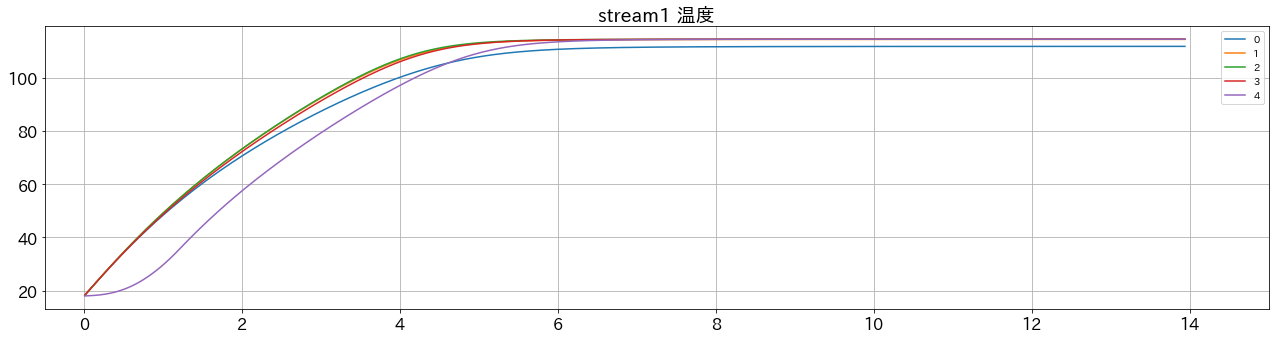

In [18]:
tgt_cols_1 = [col for col in df.columns if col.split("_")[-2][-1] == "1"]
fig = plt.figure(figsize=(18, 5), tight_layout=True)
fig.patch.set_facecolor('white')
plt.rcParams["font.size"] = 16
plt.plot(df[tgt_cols_1[0]], label=0)#, color=cm.Reds_r(0/len(tgt_cols_1)))
plt.plot(df[tgt_cols_1[1]], label=1)#, color=cm.Reds_r(1/len(tgt_cols_1)))
plt.plot(df[tgt_cols_1[2]], label=2)#, color=cm.Reds_r(1/len(tgt_cols_1)))
plt.plot(df[tgt_cols_1[3]], label=3)#, color=cm.Reds_r(1/len(tgt_cols_1)))
plt.plot(df[tgt_cols_1[4]], label=4)#, color=cm.Reds_r(1/len(tgt_cols_1)))
# plt.plot(df[tgt_cols_1[5]], label=5)#, color=cm.Reds_r(1/len(tgt_cols_1)))
# plt.plot(df[tgt_cols_1[6]], label=6)#, color=cm.Reds_r(1/len(tgt_cols_1)))
# plt.plot(df[tgt_cols_1[19]], label=19)#, color=cm.Reds_r(1/len(tgt_cols_1)))
plt.legend(fontsize=10)
plt.grid()
plt.xlim([-0.5, 15])
plt.title("stream1 温度")
plt.show()

---

In [24]:
a = set([1,2,3])
a.remove(1)
a

{2, 3}

In [19]:
a = "abbb_001_003".split("_")[:-2]
"_".join(a)

'abbb'

In [32]:
num_sec = 20
all_length = 864
l_list = np.arange(0, all_length, all_length/num_sec)
l_list += all_length / 20 / 2
l_list

array([ 21.6,  64.8, 108. , 151.2, 194.4, 237.6, 280.8, 324. , 367.2,
       410.4, 453.6, 496.8, 540. , 583.2, 626.4, 669.6, 712.8, 756. ,
       799.2, 842.4])

In [4]:
np.argmin(np.abs(l_list-1))

0

---

In [39]:
filename_list = glob.glob("../output/tmp/simulation/csv/*")
df_dict = {}
for filename in filename_list:
    df_dict[filename[len("../output/tmp/simulation/csv/"):-4]] = pd.read_csv(filename, index_col="timestamp")
pprint(df_dict.keys())
print(len(df_dict.keys()))

dict_keys(['accum_adsorp_amt', 'adsorp_amt_estimate', 'gas_cp', 'gas_density', 'Hbb', 'hw1', 'inflow_fr_co2', 'inflow_fr_n2', 'inflow_mf_co2', 'inflow_mf_n2', 'outflow_fr_co2', 'outflow_fr_n2', 'outflow_mf_co2', 'outflow_mf_n2', 'temp_reached'])
15


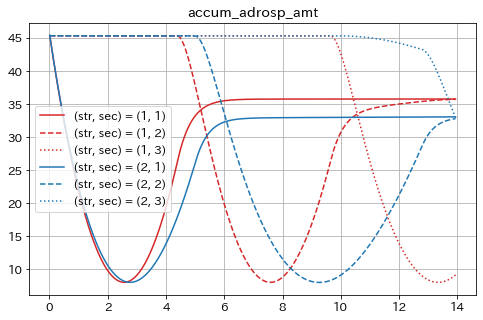

In [37]:
plt.rcParams["font.size"] = 12
plt.figure(figsize=(8,5))

linestyle_dict = {
    "1": "-",
    "2": "--",
    "3": ":",
}
color_dict = {
    "1": "tab:red",
    "2": "tab:blue",
    "3": "tab:green",
}
linewidth_dict = {
    "1": 3,
    "2": 2,
    "3": 1.5,
}
for col in df_dict["accum_adsorp_amt"].columns:
    plt.plot(df_dict["accum_adsorp_amt"][col],
             label = f"(str, sec) = ({col[-2]}, {col[-1]})",
             linestyle = linestyle_dict[col[-1]],
             c = color_dict[col[-2]],
            #  linewidth = linewidth_dict[col[-1]]
             )
plt.grid()
plt.legend()
plt.title("accum_adrosp_amt")
plt.show()

---

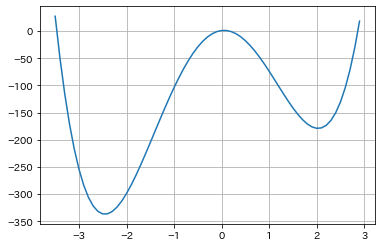

In [2]:
def f(x, a, b):
    return (a*x**4 + b*x**3 -100*x**2 + 10*x+1)

a = 10
b = 5
x = np.arange(-3.5, 3, 0.1)
y = [f(i, a, b) for i in x]
plt.plot(x,y)
plt.grid()

In [9]:
optimize.brentq(f, -1, 10, args=(a,b))

2.8646806139525482

In [19]:
optimize.newton(f, 0.1, args=(a,b))

0.16308226728797964